# TEST PIPELINE

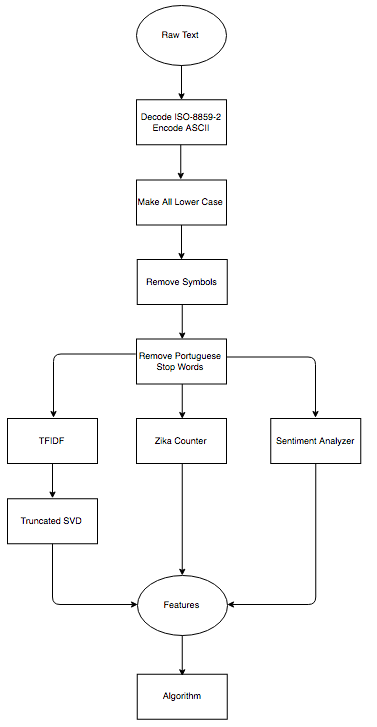

In [1]:
from IPython.display import Image
Image(filename='pipeline_flow_chart.png')

## IMPORTS

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.base import TransformerMixin
import pandas as pd
import numpy as np
import csv
import re

/Users/marwinko/anaconda/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## LOAD DATA

In [3]:
df = pd.read_csv('data/161207_ZikaLabels.csv')
df.dropna(axis=0,inplace=True)
X = df.diagnosisRAW

## DECODE ISO-8859-2 & ENCODE ASCII

In [4]:
class AsciiTransformer(TransformerMixin):
    def transform(self,X,**transform_params):     
        if str(type(X)) != "<class 'pandas.core.series.Series'>":
            X = pd.Series(X)
        return X.apply(lambda x: x.decode('ISO-8859-2').encode('ASCII','ignore'))
#         return pd.Series(X.apply(lambda x: x.decode('ISO-8859-2').encode('ASCII','ignore')))
    def fit(self,X,y=None,**fit_params):
        return self
t1 = AsciiTransformer().fit_transform(X)
print t1[:10]
print len(t1)

0                               estava somente gripado
1    Me passou remdios para enchaqueca , soro e o d...
2        repouso e tomar agua e o remedio nimesulida!!
3                                                  yes
4                                                  60%
5                                               Hiniti
6     Pediu para eu ficar de repouso e no ir trabalhar
7                                               Fimose
8    Ele afirmou que eu no tinha nenhum tipo de zik...
9                                     Apenas uma gripe
Name: diagnosisRAW, dtype: object
6983


## MAKE LOWERCASE

In [5]:
class LowerCaseTransformer(TransformerMixin):
    def transform(self,X,**transform_params):
        return pd.Series(X.apply(lambda x: x.lower()))
    def fit(self,X,y=None,**fit_params):
        return self
t2 = LowerCaseTransformer().fit_transform(t1)
print t2[:10]
print len(t2)

0                               estava somente gripado
1    me passou remdios para enchaqueca , soro e o d...
2        repouso e tomar agua e o remedio nimesulida!!
3                                                  yes
4                                                  60%
5                                               hiniti
6     pediu para eu ficar de repouso e no ir trabalhar
7                                               fimose
8    ele afirmou que eu no tinha nenhum tipo de zik...
9                                     apenas uma gripe
Name: diagnosisRAW, dtype: object
6983


## REMOVE SYMBOLS

In [6]:
class RemoveSymsTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return pd.Series(X.apply(lambda x: re.sub(re.compile(r'[^A-za-z0-9\s\.]'),' ',x)))
    def fit(self, X, y=None, **fit_params):
        return self
t3 = RemoveSymsTransformer().fit_transform(t2)
print t3[:10]
print len(t3)

0                               estava somente gripado
1    me passou remdios para enchaqueca   soro e o d...
2        repouso e tomar agua e o remedio nimesulida  
3                                                  yes
4                                                  60 
5                                               hiniti
6     pediu para eu ficar de repouso e no ir trabalhar
7                                               fimose
8    ele afirmou que eu no tinha nenhum tipo de zik...
9                                     apenas uma gripe
Name: diagnosisRAW, dtype: object
6983


## REMOVE STOP WORDS

In [7]:
class RemoveStopWordsTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        with open('pt_stop_words.txt','rb') as f:
            stop = []
            reader = csv.reader(f)
            for word in reader:
                word = word[0].split()[0].decode('ISO-8859-2').encode('ASCII','ignore')
                if word == '':
                    pass
                else:
                    stop.append(word)
        return pd.Series(X.apply(lambda x: ' '.join([token for token in x.split() if token not in stop])))
    def fit(self, X, y=None, **fit_params):
        return self
t4 = RemoveStopWordsTransformer().fit_transform(t3)
empty_index = []
for i,text in enumerate(t4):
    if text == '':
#         print '!!!!!!!!!!!!',i,text
        empty_index.append(i)
print t4[:10]
print len(t4)

0                                      somente gripado
1    passou remdios enchaqueca soro diagnstico infe...
2                repouso tomar agua remedio nimesulida
3                                                  yes
4                                                   60
5                                               hiniti
6                     pediu ficar repouso ir trabalhar
7                                               fimose
8                        afirmou nenhum tipo zika saca
9                                         apenas gripe
Name: diagnosisRAW, dtype: object
6983


## ZIKA WORD COUNTER

In [8]:
class ZikaCounterTransformer(TransformerMixin):
    def transform(self,X,**transform_params):
        return pd.Series(X.apply(lambda x: len(re.findall(r'z.{2}a',x)))).values.reshape(-1,1)
    def fit(self,X,y=None,**fit_params):
        return self
f1 = ZikaCounterTransformer().fit_transform(t4)
print f1[:10]
print len(f1)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]]
6983


## SENTIMENT ANALYZER
- not utilized since senntiment is built on english corpus
- in future, can use spanish twitter corpus OR GYANT's own message corpus

In [9]:
class SentimentTransformer(TransformerMixin):
    def transform(self,X,**transform_params):
        matrix = []
        sa = SentimentIntensityAnalyzer()
        for text in X:
            senti = sa.polarity_scores(text)
            matrix.append([senti['pos'],senti['neu'],senti['neg'],senti['compound']])
        return pd.DataFrame(data=matrix,columns=['positive','neutral','negative','compound']).values
    def fit(self,X,y=None,**fit_params):
        return self    
f2 = SentimentTransformer().fit_transform(t4)
print f2[:10]
print len(f2)

[[ 0.      1.      0.      0.    ]
 [ 0.      0.755   0.245  -0.3818]
 [ 0.      1.      0.      0.    ]
 [ 1.      0.      0.      0.4019]
 [ 0.      1.      0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      1.      0.      0.    ]]
6983


## LATENT SEMANTIC ANALYSIS (LSA)

### TERM FREQUENCY - INVERSE DOCUMENt FREQUENCY (TFIDF)

In [10]:
f3A = TfidfVectorizer().fit_transform(t4)
print f3A[:2]

  (0, 1221)	0.774738690229
  (0, 2311)	0.632281552683
  (1, 1211)	0.328278267704
  (1, 1640)	0.194753740367
  (1, 1366)	0.391688937059
  (1, 1332)	0.297714342697
  (1, 764)	0.378040473811
  (1, 2314)	0.348517634656
  (1, 881)	0.422080727799
  (1, 2123)	0.29373878914
  (1, 1844)	0.288853851929


## SINGULAR VALUE DECOMPOSITION (SVD)
- similar to PCA, but more computationally efficient

In [11]:
f3B = TruncatedSVD(100).fit_transform(f3A)
print f3B[:2]

[[  1.01101185e-03   2.11701654e-04   2.14083386e-03   5.47975033e-04
   -2.19857834e-05  -6.29617809e-05   1.20814605e-05   5.97485113e-05
   -3.88977752e-05   1.41232684e-05   1.39525914e-04   2.13205445e-04
    3.01779324e-03   8.65965742e-03   2.09318192e-03   4.42265440e-03
   -9.28720845e-07  -2.20417195e-03  -1.56051607e-06   3.90209753e-04
    4.26416346e-04   5.36661106e-03  -8.82092571e-04   1.18099532e-02
    1.09566798e-02  -4.40567664e-03  -5.07243209e-04  -4.08745853e-05
    4.38638638e-03   2.15227158e-03   4.49709761e-03   8.39209250e-03
    1.58384751e-03  -1.31557918e-04  -6.11153986e-04  -9.65126578e-04
   -2.34827573e-04  -1.14459797e-03   5.16306223e-04  -1.03843364e-04
    9.28919375e-04   2.24403342e-04  -1.39981280e-03  -7.55220735e-04
   -1.33876863e-03  -1.27604265e-03   1.58074022e-04  -4.78077652e-04
   -4.88837833e-04  -2.93772205e-03  -6.89050883e-04  -5.57692586e-05
   -1.28316512e-04  -5.03760848e-04  -1.59489714e-03   5.53627641e-04
    5.87498924e-04  

## TESTING FULL PIPELINE

In [12]:
from sklearn.pipeline import make_pipeline,make_union
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB

In [13]:
df = pd.read_csv('data/161207_ZikaLabels.csv')
df.dropna(axis=0,inplace=True)
X = df.diagnosisRAW
y = df.zika
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### PIPE #1

In [14]:
pipeline = make_pipeline(AsciiTransformer(),
                        LowerCaseTransformer(),
                        RemoveSymsTransformer(),
                        RemoveStopWordsTransformer(),
                        TfidfVectorizer(), # LSA only
                        TruncatedSVD(500),
                        GaussianNB())
model = pipeline.fit(X_train,y_train)
print 'Prediction:', model.predict('eu tenho o virus zika')
print 'Score:', model.score(X_test,y_test)

Prediction: [ True]
Score: 0.3085182534


### PIPE #2

In [15]:
pipeline = make_pipeline(AsciiTransformer(),
                        LowerCaseTransformer(),
                        RemoveSymsTransformer(),
                        RemoveStopWordsTransformer(),
                        ZikaCounterTransformer(), # zika counter only
                        GaussianNB())
model = pipeline.fit(X_train,y_train)
print 'Prediction:', model.predict('eu tenho o virus zika')
print 'Score:', model.score(X_test,y_test)

Prediction: [False]
Score: 0.928418038654


### PIPE #3

In [16]:
pipeline = make_pipeline(AsciiTransformer(),
                        LowerCaseTransformer(),
                        RemoveSymsTransformer(),
                        RemoveStopWordsTransformer(),
                        SentimentTransformer(), # sentiment only
                        GaussianNB())
model = pipeline.fit(X_train,y_train)
print 'Prediction:', model.predict('eu tenho o virus zika')
print 'Score:', model.score(X_test,y_test)

Prediction: [ True]
Score: 0.106657122405


### PIPE #4

In [17]:
lsa = make_pipeline(TfidfVectorizer(),TruncatedSVD(500))
feature_union = make_union(lsa,ZikaCounterTransformer(), SentimentTransformer()) 
pipeline = make_pipeline(AsciiTransformer(),
                        LowerCaseTransformer(),
                        RemoveSymsTransformer(),
                        RemoveStopWordsTransformer(),
                        feature_union,
                        GaussianNB())
model = pipeline.fit(X_train,y_train)
print 'Prediction:', model.predict('eu tenho o virus zika')
print 'Score:', model.score(X_test,y_test)



Prediction: [ True]
Score: 0.301360057266
